In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from operator import itemgetter
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

/Users/wesleyfitters/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
def MAPE(y_true, y_pred):
    y = [x for x in y_true if x > 0]
    y_pred = [y_pred[i] for i in range(len(y_true)) if y_true[i] > 0]
    num = len(y_pred)
    sums = 0
    for i in range(num):
        tmp = abs(y[i] - y_pred[i]) / y[i]
        sums += tmp
    mape = sums * (100 / num)
    return mape

import math
def eva_regress(y_true, y_pred):
    mape = MAPE(y_true, y_pred)
    vs = metrics.explained_variance_score(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print('explained_variance_score:%f' % vs)
    print('mape:%f%%' % mape)
    print('mae:%f' % mae)
    print('mse:%f' % mse)
    print('rmse:%f' % math.sqrt(mse))
    print('r2:%f' % r2)

In [4]:
correlations = pd.read_csv('../../DCP-HTO/calculated_correlation/correlation_current.csv')
correlations = correlations.drop('Unnamed: 0',axis=1)

In [5]:
def one_hot_outliers(df,k):
    intersections = df.columns
    odf = pd.DataFrame()
    for intersection in intersections:
        y = df[intersection]
        boundary = y.sort_values().head(k)[-1]#Get K lowest LOF score and use as boundary 
        print('Boundary is set to: ', boundary)
        odf['ol_'+intersection] = y.apply(make_binary,boundary=boundary)
    return odf
    
#Make the label a binary of outlier or not.
def make_binary(row,boundary):
    if row <= boundary:
        row = 1
    else:
        row = 0
    return row

In [6]:
tflow_file = '../../DCP-HTO/SFPD-LOF/input_data/other_intersections/'
tflow = pd.read_csv(tflow_file+'K302.csv',index_col=["timestamp"], parse_dates=True)
#sel = ['K173','K414','K158','K402','K305']
sel = [
    'K173','K414','K158','K402','K305',
    'K071','K097','K124','K128','K159','K184','K189','K206','K225','K270','K304','K405','K406','K424','K430','K703','K704','K707','K711','K561','K504','K145','K250',
    'a12in','a12out','n211in','n211out','n141in','n141out','n142in','n142out','n143in','n143out'
]
for i in sel:
    #print(i)
    x = pd.read_csv(tflow_file+i+'.csv',index_col=["timestamp"], parse_dates=True)
    tflow = pd.merge(tflow, x, on='timestamp',how='left')


#for f in filenames:
 #   dataframes.append(pd.read_csv(f))

In [7]:
tflow = tflow.fillna(method='ffill')
tflow = tflow.fillna(0)

In [8]:
tflow.shape

(152976, 41)

In [9]:
tflow.head()

,K302,K173,K414,K158,K402,K305,K071,K097,K124,K128,...,Unnamed: 0_y,a12out,n211in,n211out,n141in,n141out,n142in,n142out,n143in,n143out
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,40.0,15.0,0.0,0.0,0.0,49.0,0.0,0.0,0.0,140.0,...,0.0,208.0,0.0,44.0,76.0,40.0,84.0,48.0,40.0,60.0
2015-01-01 00:15:00,93.0,29.0,0.0,0.0,0.0,131.0,0.0,0.0,0.0,225.0,...,1.0,460.0,0.0,144.0,64.0,64.0,68.0,64.0,32.0,44.0
2015-01-01 00:30:00,148.0,58.0,0.0,0.0,0.0,227.0,0.0,0.0,0.0,247.0,...,2.0,1044.0,0.0,392.0,160.0,248.0,148.0,280.0,180.0,60.0
2015-01-01 00:45:00,171.0,69.0,0.0,0.0,0.0,342.0,0.0,0.0,0.0,346.0,...,3.0,1484.0,404.0,468.0,292.0,400.0,296.0,412.0,316.0,152.0
2015-01-01 01:00:00,181.0,138.0,0.0,0.0,0.0,465.0,0.0,0.0,0.0,323.0,...,4.0,1644.0,648.0,852.0,424.0,608.0,404.0,644.0,404.0,328.0


# All intersection data!

In [10]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [11]:
# load dataset
#dataset = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv', header=0,index_col=0)
values = tflow.values
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [12]:
# specify the number of lag hours
n_hours = 12
n_features = 41

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

In [13]:
# split into train and test sets
values = reframed.values
n_train_hours = 140256
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [14]:
# split into input and outputs
n_obs = n_hours * n_features

In [15]:
train_X, train_y = train[:, :n_obs], train[:, -n_features]

In [16]:
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [17]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(140256, 12, 41) (140256,) (12708, 12, 41) (12708,)


Train on 140256 samples, validate on 12708 samples
Epoch 1/50
 - 12s - loss: 0.0321 - val_loss: 0.0336
Epoch 2/50
 - 12s - loss: 0.0256 - val_loss: 0.0320
Epoch 3/50
 - 12s - loss: 0.0243 - val_loss: 0.0323
Epoch 4/50
 - 12s - loss: 0.0235 - val_loss: 0.0301
Epoch 5/50
 - 12s - loss: 0.0228 - val_loss: 0.0305
Epoch 6/50
 - 12s - loss: 0.0224 - val_loss: 0.0308
Epoch 7/50
 - 12s - loss: 0.0222 - val_loss: 0.0303
Epoch 8/50
 - 13s - loss: 0.0219 - val_loss: 0.0295
Epoch 9/50
 - 11s - loss: 0.0216 - val_loss: 0.0291
Epoch 10/50
 - 11s - loss: 0.0213 - val_loss: 0.0298
Epoch 11/50
 - 11s - loss: 0.0212 - val_loss: 0.0284
Epoch 12/50
 - 11s - loss: 0.0210 - val_loss: 0.0290
Epoch 13/50
 - 11s - loss: 0.0208 - val_loss: 0.0288
Epoch 14/50
 - 11s - loss: 0.0207 - val_loss: 0.0284
Epoch 15/50
 - 11s - loss: 0.0206 - val_loss: 0.0282
Epoch 16/50
 - 11s - loss: 0.0205 - val_loss: 0.0287
Epoch 17/50
 - 11s - loss: 0.0204 - val_loss: 0.0282
Epoch 18/50
 - 11s - loss: 0.0203 - val_loss: 0.0274
Epoc

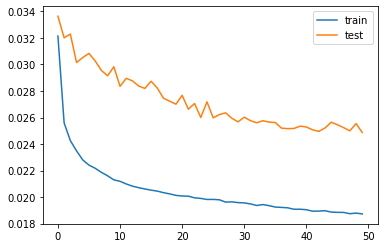

In [18]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [19]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

In [20]:
# invert scaling for forecast
old_inv_yhat = concatenate((yhat, test_X[:, -40:]), axis=1)
old_inv_yhat = scaler.inverse_transform(old_inv_yhat)
old_inv_yhat = old_inv_yhat[:,0]

In [21]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -40:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, old_inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 47.504


In [22]:
eva_regress(inv_y, old_inv_yhat)

explained_variance_score:0.963188
mape:12.182516%
mae:26.902325
mse:2256.666992
rmse:47.504389
r2:0.962400


In [201]:
df = {'LSTM':old_inv_yhat[:300],'True data':inv_y[:300]}
df = pd.DataFrame(data=df)
#df = df.set_index('datetime')

In [202]:
len(inv_y)

9124

# Advanced input data

In [26]:
#Selection based on dynamic feature reduction
sel=['K302',
 'K173',
 'K414',
 'K158',
 'K402',
 'K305',
 'K128',
 'K184',
 'K206',
 'K225',
 'K304',
 'K406',
 'K704',
 'K711',
 'K561',
 'K504',
 'K145',
 'a12in',
 'a12out',
 'n211out',
 'n141in',
 'n141out',
 'n142in',
 'n143out'
    ]

In [27]:
fpd = pd.read_csv('../../DCP-HTO/dataframe_creation/complete_dataframe.csv',index_col=0, parse_dates=True)
fpd = fpd.fillna(1)
fpd_sel = fpd[sel]

In [28]:
odf = one_hot_outliers(fpd_sel,50)

Boundary is set to:  0.7885561944522245
Boundary is set to:  0.779821891146718
Boundary is set to:  0.8149445361187684
Boundary is set to:  0.8505151891376066
Boundary is set to:  0.8565726043523633
Boundary is set to:  0.8767753856185738
Boundary is set to:  0.7525199591873765
Boundary is set to:  0.6298304810739711
Boundary is set to:  0.8059338513051981
Boundary is set to:  0.7227470601760492
Boundary is set to:  0.5975604947324116
Boundary is set to:  0.6838285319387081
Boundary is set to:  0.7807468641783332
Boundary is set to:  0.7565255220206187
Boundary is set to:  0.7836740937920208
Boundary is set to:  0.7760184321476016
Boundary is set to:  0.7856204482313128
Boundary is set to:  0.8339441072149688
Boundary is set to:  0.8302674128695837
Boundary is set to:  0.8634860681417491
Boundary is set to:  0.7597328303748593
Boundary is set to:  0.7776867194037409
Boundary is set to:  0.7738571337715838
Boundary is set to:  0.6501212945960191


In [29]:
rodf = odf.resample('15T').pad()

In [382]:
rodf.shape

(148605, 24)

In [31]:
rodf.index.name = 'timestamp'

In [32]:
tflow_file = '../../DCP-HTO/SFPD-LOF/input_data/other_intersections/'
tflow = pd.read_csv(tflow_file+'K302.csv',index_col=["timestamp"], parse_dates=True)
for i in sel:
    #print(i)
    x = pd.read_csv(tflow_file+i+'.csv',index_col=["timestamp"], parse_dates=True)
    tflow = pd.merge(tflow, x, on='timestamp',how='left')

In [33]:
tflow = tflow.drop(columns=['Unnamed: 0_x','Unnamed: 0_y'],axis=1)

In [34]:
tflow = pd.merge(tflow, rodf, on='timestamp',how='left')

In [35]:
tflow = tflow.fillna(method='ffill')
tflow = tflow.fillna(0)

In [36]:
dti = tflow['K414']

In [37]:
dti = dti[140256:]

In [41]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [42]:
values = tflow.values
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [43]:
# specify the number of lag hours
n_hours = 12
n_features =49

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

In [44]:
# split into train and test sets
values = reframed.values
n_train_hours = 140256
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [45]:
# split into input and outputs
n_obs = n_hours * n_features

In [46]:
train_X, train_y = train[:, :n_obs], train[:, -n_features]

In [47]:
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [48]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(140256, 12, 49) (140256,) (9124, 12, 49) (9124,)


Train on 140256 samples, validate on 9124 samples
Epoch 1/50
 - 12s - loss: 0.0307 - val_loss: 0.0292
Epoch 2/50
 - 11s - loss: 0.0243 - val_loss: 0.0269
Epoch 3/50
 - 11s - loss: 0.0233 - val_loss: 0.0262
Epoch 4/50
 - 11s - loss: 0.0227 - val_loss: 0.0258
Epoch 5/50
 - 11s - loss: 0.0224 - val_loss: 0.0254
Epoch 6/50
 - 11s - loss: 0.0218 - val_loss: 0.0254
Epoch 7/50
 - 11s - loss: 0.0216 - val_loss: 0.0255
Epoch 8/50
 - 11s - loss: 0.0214 - val_loss: 0.0258
Epoch 9/50
 - 11s - loss: 0.0211 - val_loss: 0.0255
Epoch 10/50
 - 11s - loss: 0.0211 - val_loss: 0.0256
Epoch 11/50
 - 11s - loss: 0.0209 - val_loss: 0.0257
Epoch 12/50
 - 11s - loss: 0.0207 - val_loss: 0.0256
Epoch 13/50
 - 11s - loss: 0.0206 - val_loss: 0.0251
Epoch 14/50
 - 11s - loss: 0.0205 - val_loss: 0.0248
Epoch 15/50
 - 11s - loss: 0.0204 - val_loss: 0.0245
Epoch 16/50
 - 11s - loss: 0.0203 - val_loss: 0.0247
Epoch 17/50
 - 11s - loss: 0.0202 - val_loss: 0.0246
Epoch 18/50
 - 11s - loss: 0.0201 - val_loss: 0.0248
Epoch

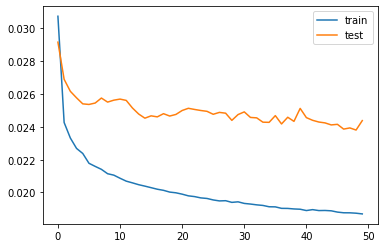

In [49]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [50]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

In [51]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -48:]), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [52]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -48:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 44.716


In [53]:
eva_regress(inv_y, inv_yhat)

explained_variance_score:0.967506
mape:10.910447%
mae:26.381092
mse:1999.513184
rmse:44.715916
r2:0.967312


In [54]:
df = {'LSTM':inv_yhat[:300],'True data':inv_y[:300]}
df = pd.DataFrame(data=df)
#df = df.set_index('datetime')

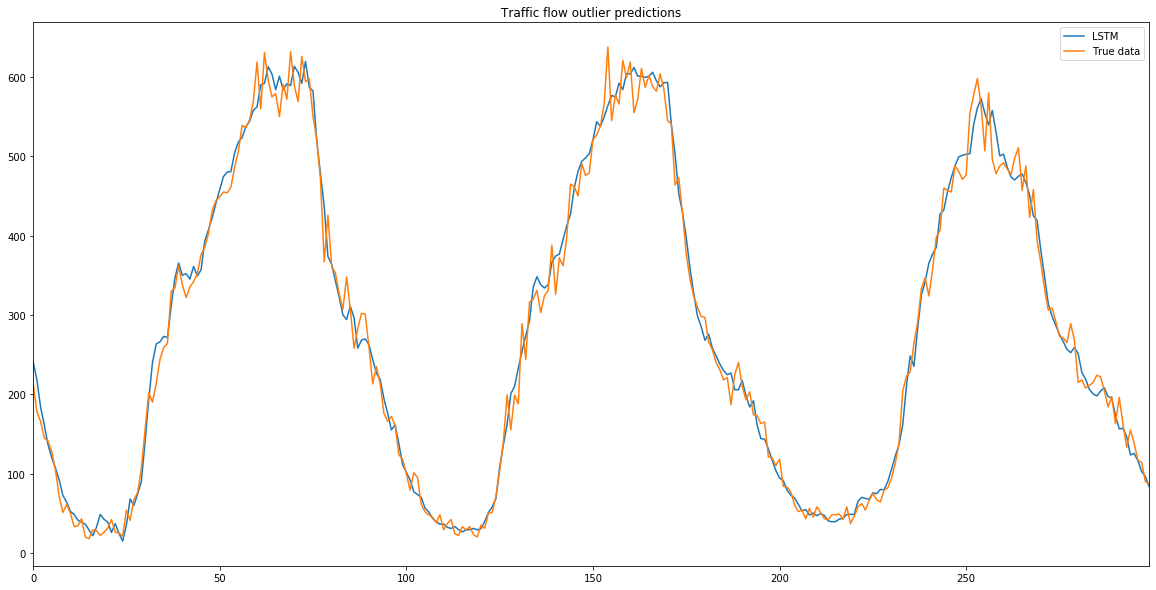

In [55]:
df.plot(y=['LSTM','True data'],figsize=(20,10),title='Traffic flow outlier predictions')

In [286]:
ndti = dti[496:]

In [287]:
ndf = {'LSTM':inv_yhat[484:],'True data':inv_y[484:],'datetime':ndti.index}
ndf = pd.DataFrame(data=ndf)
ndf = ndf.set_index('datetime')

# Outlier zoom

In [288]:
k302 = pd.read_csv('../dat/traffic_intersection_selection.csv', index_col=["timestamp"], usecols=["timestamp","K414"], parse_dates=True)
testol = k302['2019':]
testolindex = testol.sort_values('K414').head(10).index
strdatetimes = [str(a) for a in testolindex]
sliced = []
for item in strdatetimes:
    sliced.append(item[:13]+':00:00')
    sliced.append(item[:13]+':15:00')
    sliced.append(item[:13]+':30:00')
    sliced.append(item[:13]+':45:00')
test_dat = pd.read_csv('../TFP_adapted/data/new_test.csv',parse_dates=['timestamp'])
olindexes = test_dat[test_dat.timestamp.isin(sliced)].index

In [289]:
andf = ndf[ndf.index.isin(sliced)]
def get_diff(row):
    return row['True data'] - row ['LSTM']
andf['diff'] = andf.apply(get_diff,axis=1)

/Users/wesleyfitters/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [290]:
#andf = andf.sort_values('diff',ascending=False)[:10]

In [291]:
#andf = andf.drop('diff',axis=1)

In [292]:
eva_regress(andf['True data'], andf['LSTM'])

explained_variance_score:0.913650
mape:16.879671%
mae:14.263777
mse:597.229492
rmse:24.438279
r2:0.906126


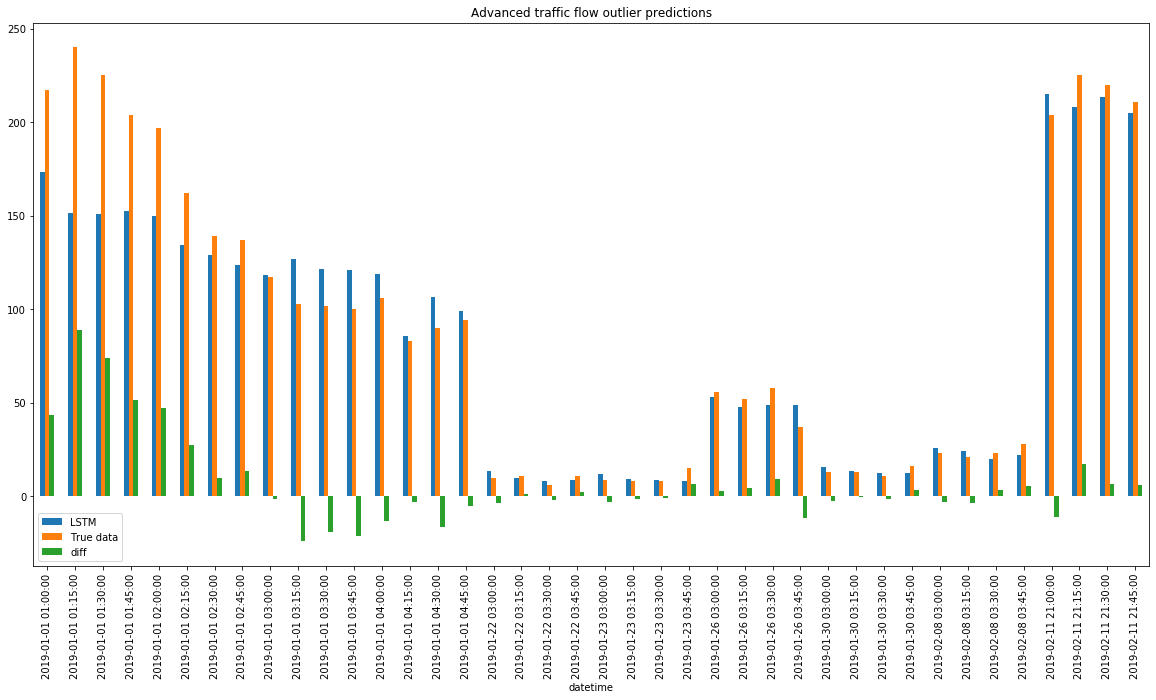

In [293]:
andf.plot(kind='bar',figsize=(20,10),title='Advanced traffic flow outlier predictions')

# OLD

In [294]:
old_ndf = {'LSTM':old_inv_yhat[4068:],'True data':inv_y[484:],'datetime':ndti.index}
old_ndf = pd.DataFrame(data=old_ndf)
old_ndf = old_ndf.set_index('datetime')

In [295]:
k302 = pd.read_csv('../dat/traffic_intersection_selection.csv', index_col=["timestamp"], usecols=["timestamp","K414"], parse_dates=True)
testol = k302['2019':]
testolindex = testol.sort_values('K414').head(10).index
strdatetimes = [str(a) for a in testolindex]
sliced = []
for item in strdatetimes:
    sliced.append(item[:13]+':00:00')
    sliced.append(item[:13]+':15:00')
    sliced.append(item[:13]+':30:00')
    sliced.append(item[:13]+':45:00')
test_dat = pd.read_csv('../TFP_adapted/data/new_test.csv',parse_dates=['timestamp'])
olindexes = test_dat[test_dat.timestamp.isin(sliced)].index

In [296]:
bandf = old_ndf[old_ndf.index.isin(sliced)]
def get_diff(row):
    return row['True data'] - row ['LSTM']
bandf['diff'] = bandf.apply(get_diff,axis=1)

/Users/wesleyfitters/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [297]:
#bandf = bandf.sort_values('diff',ascending=False)[:10]

In [298]:
old_diff = bandf['diff']

In [299]:
bandf = bandf.drop('diff',axis=1)
bandf = bandf.sort_index()

In [300]:
eva_regress(bandf['True data'], bandf['LSTM'])

explained_variance_score:0.931810
mape:31.091121%
mae:15.098844
mse:467.011871
rmse:21.610457
r2:0.926594


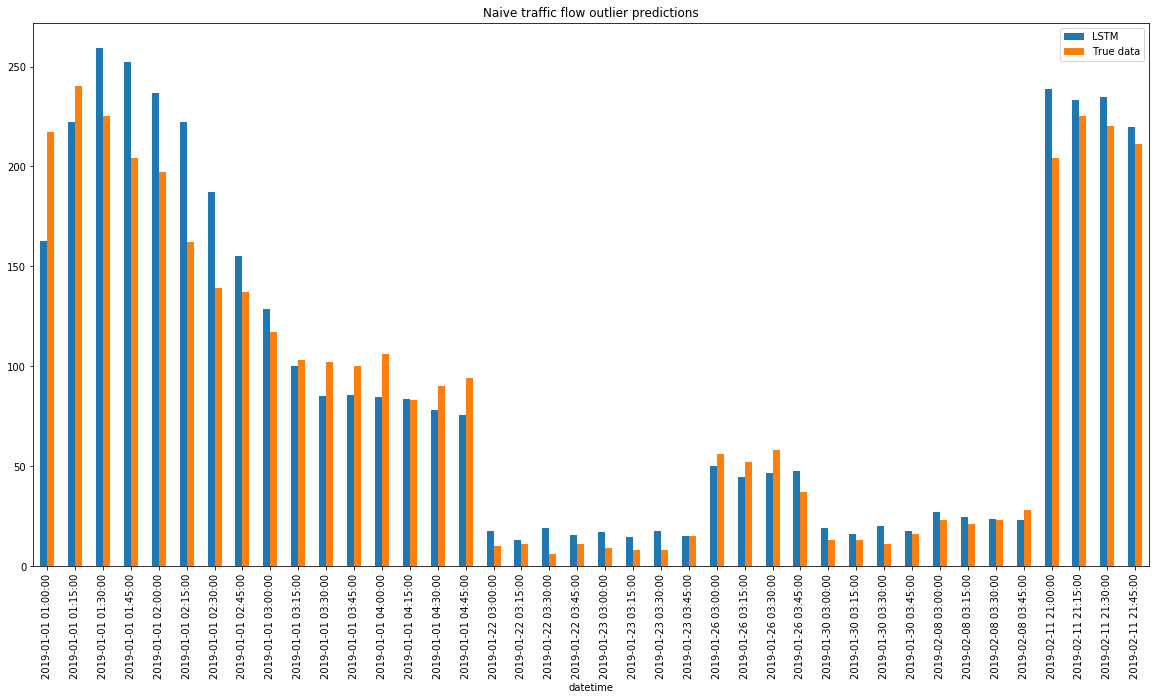

In [301]:
bandf.plot(kind='bar',figsize=(20,10),title='Naive traffic flow outlier predictions')

In [401]:
import matplotlib as mpl
def plot_results(y_true, y_preds, names):
    """Plot
    Plot the true data and predicted data.

    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
        names: List, Method names.
    """
    d = '2020-1-4 00:00'
    x = pd.date_range(d, periods=len(y_true), freq='15min')

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(x, y_preds[0], label=names[0],color='#ff7f0e')
    ax.plot(x, y_true, label='True Data',color='#1f77b4')
        

    plt.legend()
    plt.grid(True)
    plt.xlabel('Time of Day')
    plt.ylabel('Flow')

    date_format = mpl.dates.DateFormatter("%d-%m %H:%M")
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()

    plt.show()

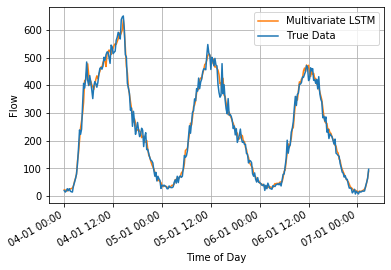

In [402]:
plot_pred = [old_ndf['LSTM'][300:600]]
plot_true = old_ndf['True data'][300:600]
plot_results(plot_true,plot_pred,['Multivariate LSTM'])

# Combined plot

In [307]:
naive_pred = bandf.LSTM

In [308]:
andf['naive'] = naive_pred
andf['old_diff'] = old_diff

/Users/wesleyfitters/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/wesleyfitters/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


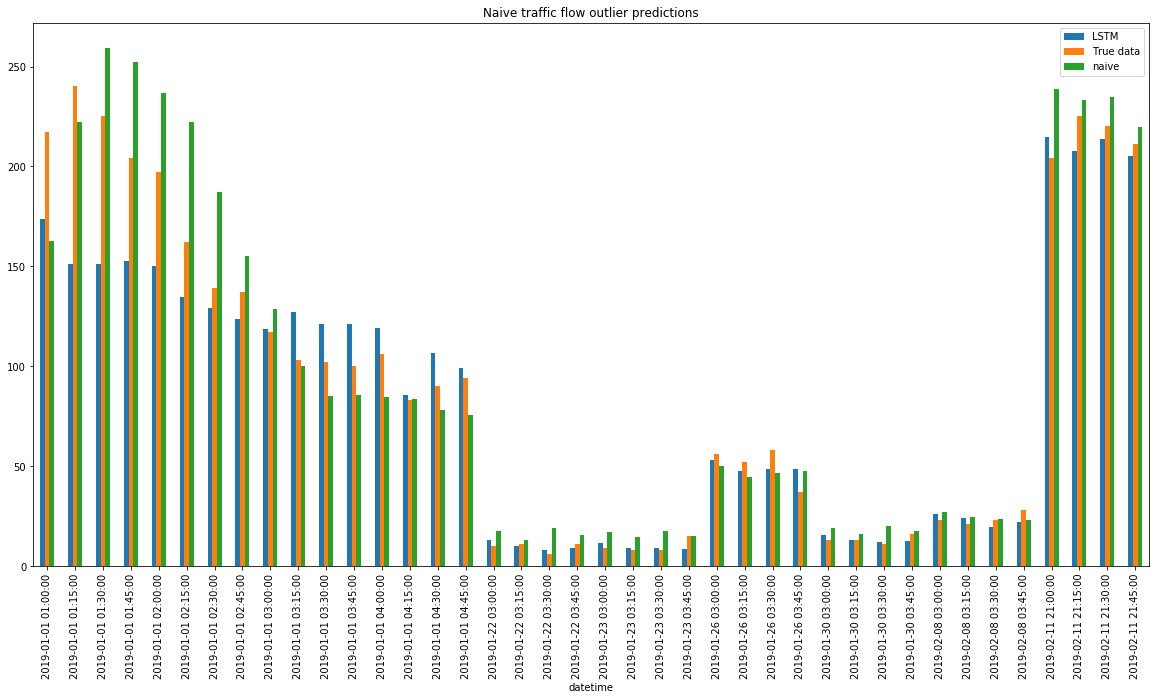

In [309]:
andf[['LSTM','True data','naive']].plot(kind='bar',figsize=(20,10),title='Naive traffic flow outlier predictions')

# Hourly

In [358]:
nandf = andf.resample('H').first()
nandf = nandf[nandf.LSTM >0]
#nandf = nandf.drop('diff',axis=1)

In [359]:
del nandf.index.name

In [360]:
nandf = nandf.rename(columns={"naive": "Multivariate LSTM"})
nandf = nandf.rename(columns={"LSTM": "OE-LSTM"})

In [385]:
temp_ind = nandf.index

In [392]:
new_ind = []
for item in temp_ind:
    new_ind.append(str(item)[5:-3])

In [394]:
nandf.index = new_ind

# Results

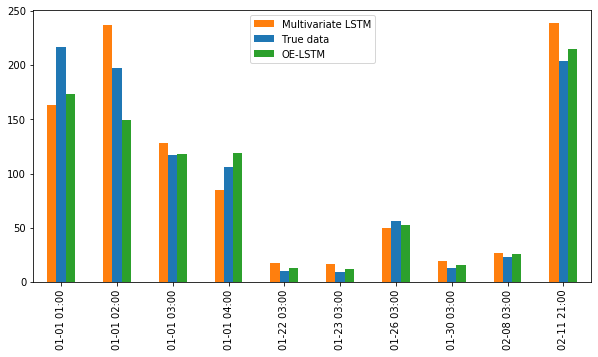

In [403]:
nandf[['Multivariate LSTM','True data','OE-LSTM']].plot(kind='bar',figsize=(10,5),fontsize=10,color=['#ff7f0e','#1f77b4','#2ca02c'])

In [259]:
#nandf[['diff','old_diff']].abs().plot(kind='bar',figsize=(20,10),title='Advanced traffic flow outlier predictions')

# Mapes

In [341]:
mape_dat = {'Naive LSTM':[12.18,31.09],'OE-LSTM':[10.91,16.87]}

In [342]:
mape_df = pd.DataFrame(mape_dat)

In [343]:
mape_df.index = ['All test data','Top outliers']

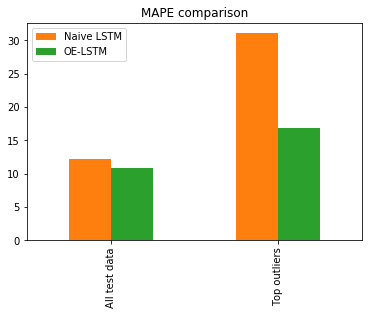

In [349]:
color_dict = {'Naive LSTM': '#1f77b4', 'OE-LSTM': '#2ca02c'}

# use get to specify dark gray as the default color.
mape_df.plot(kind='bar',title='MAPE comparison',color=['#ff7f0e','#2ca02c'])
plt.show()